In [ ]:
!pip install requests pandas implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 30.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse
import requests
from implicit.als import AlternatingLeastSquares

# Your API Key
API_KEY = '82dfb0a48cca5b67b83472a7be67f78a'  # Ensure this is correct

# Function to get top artists for a given user from Last.fm
def get_user_top_artists(user, limit=10):
    """
    Fetch the top artists for a specific user from Last.fm API.
    """
    url = f"http://ws.audioscrobbler.com/2.0/?method=user.getTopArtists&user={user}&api_key={API_KEY}&format=json&limit={limit}"
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code != 200:
        raise Exception(f"Error fetching data from Last.fm. Status Code: {response.status_code}")

    data = response.json()

    # Check if the data contains the expected structure
    if 'topartists' not in data or 'artist' not in data['topartists']:
        raise Exception(f"Unexpected API response format: {data}")

    # Convert data to a Pandas DataFrame
    artists = data['topartists']['artist']
    df = pd.DataFrame([{'user': user, 'artist': artist['name'], 'playcount': int(artist['playcount'])} for artist in artists])

    return df

# Function to prepare the user-artist matrix
def create_user_artist_matrix(data):
    """
    Convert the Last.fm user data (artist and play counts) into a sparse matrix format.
    """
    # 'data' should be a DataFrame with columns ['user', 'artist', 'playcount']
    data['user_id'] = data['user'].astype('category').cat.codes
    data['artist_id'] = data['artist'].astype('category').cat.codes

    user_artist_matrix = scipy.sparse.coo_matrix(
        (
            data['playcount'].astype(float),
            (data['user_id'], data['artist_id'])
        )
    )
    return user_artist_matrix.tocsr(), data

# Fetch user data
user = 'zeden1'
try:
    user_artists_df = get_user_top_artists(user, limit=10)
    print(f"Top Artists for User: {user}")
    print(user_artists_df)
except Exception as e:
    print(f"Error: {e}")

# Prepare the user-artist matrix
user_artist_matrix, processed_data = create_user_artist_matrix(user_artists_df)

# Fit the ALS model
model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=10)
model.fit(user_artist_matrix)

# Function to recommend artists for a specific user
def recommend_artists(model, user_id, data, n=5):
    """
    Recommend top N artists for a specific user.
    """
    # Ensure the user_items matrix is in CSR format
    user_items = user_artist_matrix.tocsr()  # User-artist interaction matrix in CSR format

    # Ensure the user ID is within bounds
    if user_id >= user_items.shape[0]:
        raise ValueError(f"User ID {user_id} is out of range. Maximum is {user_items.shape[0] - 1}.")

    # Generate recommendations
    recommended_ids, scores = model.recommend(user_id, user_items, N=n)

    # Translate artist indices back to names
    artist_id_to_name = dict(enumerate(data['artist'].astype('category').cat.categories))
    recommended_artists = [(artist_id_to_name[idx], score) for idx, score in zip(recommended_ids, scores)]

    return recommended_artists

# Example: Get recommendations for user with ID 0
user_id = 0  # Adjust this based on your dataset's user index
try:
    recommendations = recommend_artists(model, user_id, processed_data, n=5)
    print(f"\nRecommendations for User {user_id} ({user}):")
    for artist, score in recommendations:
        print(f"Artist: {artist}, Score: {score:.2f}")
except ValueError as ve:
    print(f"Value Error: {ve}")
except Exception as e:
    print(f"Unexpected Error: {e}")


Top Artists for User: zeden1
     user        artist  playcount
0  zeden1         B.o.B         94
1  zeden1    Kxllswxtch         73
2  zeden1         Bella          7
3  zeden1  XXXTENTACION          5
4  zeden1   Post Malone          4
5  zeden1         AKano          3
6  zeden1         Gavn!          3
7  zeden1      KillBunk          3
8  zeden1          King          3
9  zeden1      347aidan          2


/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]


Recommendations for User 0 (zeden1):
Artist: Gavn!, Score: -340282346638528859811704183484516925440.00
Artist: Bella, Score: -340282346638528859811704183484516925440.00
Artist: B.o.B, Score: -340282346638528859811704183484516925440.00
Artist: AKano, Score: -340282346638528859811704183484516925440.00
Artist: 347aidan, Score: -340282346638528859811704183484516925440.00


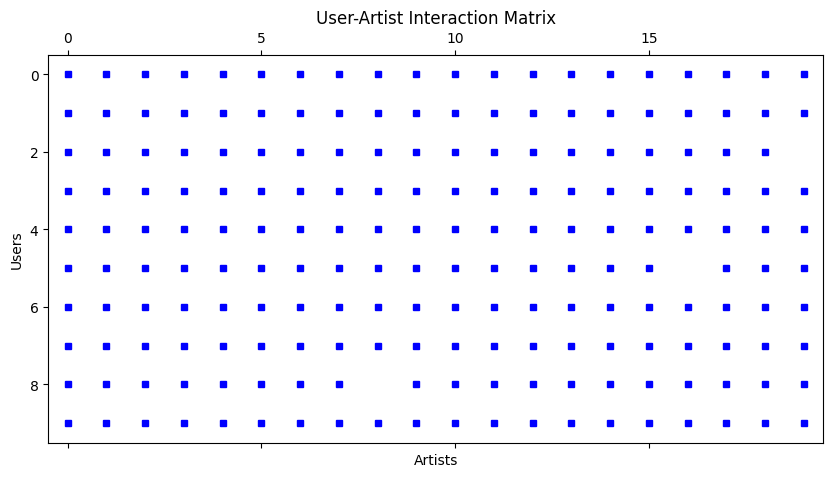

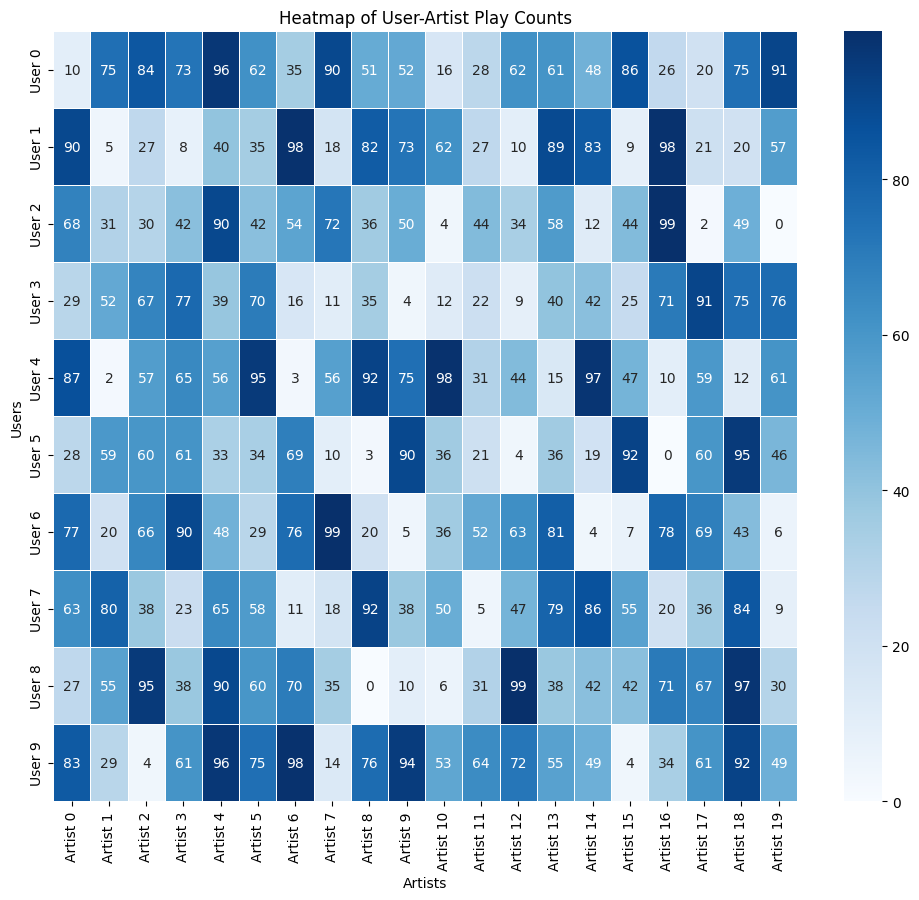

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse

# Sample Data Creation (Replace this with your actual user-artists matrix)
# Assuming `user_artists_matrix` is a scipy sparse matrix with shape (num_users, num_artists)
# Replace this with your own data processing method that creates the matrix from Last.fm data

# For the example, create a random sparse matrix for demonstration
num_users = 10
num_artists = 20
data = np.random.randint(0, 100, size=(num_users, num_artists))
user_artists_matrix = scipy.sparse.csr_matrix(data)

# 1. User-Artist Interaction Matrix
plt.figure(figsize=(10, 8))
plt.spy(user_artists_matrix, markersize=5, color="blue")
plt.title("User-Artist Interaction Matrix")
plt.xlabel("Artists")
plt.ylabel("Users")
plt.show()

# 2. Heatmap of User-Artist Play Counts
# Convert sparse matrix to dense matrix for heatmap visualization
dense_matrix = user_artists_matrix.toarray()

# Create a pandas DataFrame for better labeling
user_artist_df = pd.DataFrame(dense_matrix, columns=[f"Artist {i}" for i in range(num_artists)],
                              index=[f"User {i}" for i in range(num_users)])

# Generate heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(user_artist_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Heatmap of User-Artist Play Counts")
plt.xlabel("Artists")
plt.ylabel("Users")
plt.show()


Top Artists for User: zeden1
     user        artist  playcount
0  zeden1         B.o.B         94
1  zeden1    Kxllswxtch         73
2  zeden1         Bella          7
3  zeden1  XXXTENTACION          5
4  zeden1   Post Malone          4
5  zeden1         AKano          3
6  zeden1         Gavn!          3
7  zeden1      KillBunk          3
8  zeden1          King          3
9  zeden1      347aidan          2


  0%|          | 0/10 [00:00<?, ?it/s]


Recommendations for User 0 (zeden1):
Artist: Gavn!, Score: -340282346638528859811704183484516925440.00
Artist: Bella, Score: -340282346638528859811704183484516925440.00
Artist: B.o.B, Score: -340282346638528859811704183484516925440.00
Artist: AKano, Score: -340282346638528859811704183484516925440.00
Artist: 347aidan, Score: -340282346638528859811704183484516925440.00


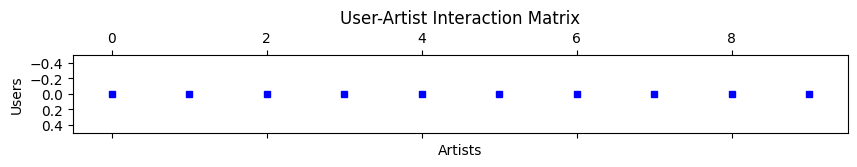

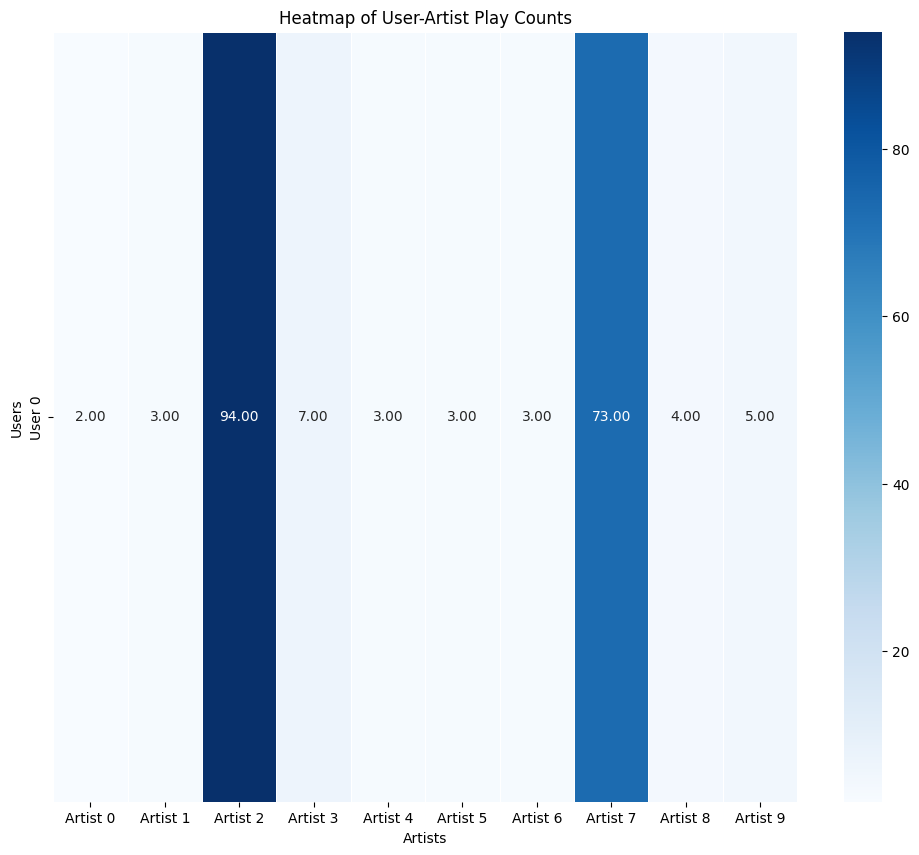

In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse
import requests
from implicit.als import AlternatingLeastSquares
import matplotlib.pyplot as plt
import seaborn as sns

# Your API Key for Last.fm
API_KEY = '82dfb0a48cca5b67b83472a7be67f78a'  # Ensure this is correct

# Function to get top artists for a given user from Last.fm
def get_user_top_artists(user, limit=10):
    """
    Fetch the top artists for a specific user from Last.fm API.
    """
    url = f"http://ws.audioscrobbler.com/2.0/?method=user.getTopArtists&user={user}&api_key={API_KEY}&format=json&limit={limit}"
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code != 200:
        raise Exception(f"Error fetching data from Last.fm. Status Code: {response.status_code}")

    data = response.json()

    # Check if the data contains the expected structure
    if 'topartists' not in data or 'artist' not in data['topartists']:
        raise Exception(f"Unexpected API response format: {data}")

    # Convert data to a Pandas DataFrame
    artists = data['topartists']['artist']
    df = pd.DataFrame([{'user': user, 'artist': artist['name'], 'playcount': int(artist['playcount'])} for artist in artists])

    return df

# Function to prepare the user-artist matrix
def create_user_artist_matrix(data):
    """
    Convert the Last.fm user data (artist and play counts) into a sparse matrix format.
    """
    data['user_id'] = data['user'].astype('category').cat.codes
    data['artist_id'] = data['artist'].astype('category').cat.codes

    user_artist_matrix = scipy.sparse.coo_matrix(
        (
            data['playcount'].astype(float),
            (data['user_id'], data['artist_id'])
        )
    )
    return user_artist_matrix.tocsr(), data

# Function to recommend artists for a specific user
def recommend_artists(model, user_id, data, n=5):
    """
    Recommend top N artists for a specific user.
    """
    user_items = user_artist_matrix.tocsr()  # User-artist interaction matrix in CSR format

    if user_id >= user_items.shape[0]:
        raise ValueError(f"User ID {user_id} is out of range. Maximum is {user_items.shape[0] - 1}.")

    recommended_ids, scores = model.recommend(user_id, user_items, N=n)

    # Translate artist indices back to names
    artist_id_to_name = dict(enumerate(data['artist'].astype('category').cat.categories))
    recommended_artists = [(artist_id_to_name[idx], score) for idx, score in zip(recommended_ids, scores)]

    return recommended_artists

# Fetch user data from Last.fm API
user = 'zeden1'
try:
    user_artists_df = get_user_top_artists(user, limit=10)
    print(f"Top Artists for User: {user}")
    print(user_artists_df)
except Exception as e:
    print(f"Error: {e}")

# Prepare the user-artist matrix
user_artist_matrix, processed_data = create_user_artist_matrix(user_artists_df)

# Fit the ALS model
model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=10)
model.fit(user_artist_matrix)

# Example: Get recommendations for user with ID 0
user_id = 0  # Adjust this based on your dataset's user index
try:
    recommendations = recommend_artists(model, user_id, processed_data, n=5)
    print(f"\nRecommendations for User {user_id} ({user}):")
    for artist, score in recommendations:
        print(f"Artist: {artist}, Score: {score:.2f}")
except ValueError as ve:
    print(f"Value Error: {ve}")
except Exception as e:
    print(f"Unexpected Error: {e}")

# Visualization 1: User-Artist Interaction Matrix
plt.figure(figsize=(10, 8))
plt.spy(user_artist_matrix, markersize=5, color="blue")
plt.title("User-Artist Interaction Matrix")
plt.xlabel("Artists")
plt.ylabel("Users")
plt.show()

# Visualization 2: Heatmap of User-Artist Play Counts
# Convert sparse matrix to dense matrix for heatmap visualization
# Visualization 2: Heatmap of User-Artist Play Counts
# Convert sparse matrix to dense matrix for heatmap visualization
dense_matrix = user_artist_matrix.toarray()

# Create a pandas DataFrame for better labeling
user_artist_df = pd.DataFrame(dense_matrix, columns=[f"Artist {i}" for i in range(user_artist_matrix.shape[1])],
                              index=[f"User {i}" for i in range(user_artist_matrix.shape[0])])

# Generate heatmap with correct formatting for float values
plt.figure(figsize=(12, 10))
sns.heatmap(user_artist_df, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5)
plt.title("Heatmap of User-Artist Play Counts")
plt.xlabel("Artists")
plt.ylabel("Users")
plt.show()
